In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import networkx as nx
from matplotlib.patches import Circle

In [2]:
# Path to the data
DATA_DIR = '../data'
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')

In [3]:
def list_scenarios():
   """List all available scenarios in the processed directory"""
   return [d for d in os.listdir(PROCESSED_DIR) 
           if os.path.isdir(os.path.join(PROCESSED_DIR, d))]

In [4]:
def load_scenario(scenario_id):
   """Load all data for a specific scenario"""
   scenario_path = os.path.join(PROCESSED_DIR, scenario_id)
   
   # Load network data
   with open(os.path.join(scenario_path, "network_road_network.json"), 'r') as f:
       road_data = json.load(f)
   
   rsus = pd.read_csv(os.path.join(scenario_path, "network_rsus.csv"))
   vehicles = pd.read_csv(os.path.join(scenario_path, "network_vehicles.csv"))
   
   with open(os.path.join(scenario_path, "network_connections.json"), 'r') as f:
       connections = json.load(f)
   
   # Load task data
   tasks = pd.read_csv(os.path.join(scenario_path, "tasks.csv"))
   
   with open(os.path.join(scenario_path, "vehicle_tasks.json"), 'r') as f:
       vehicle_tasks = json.load(f)
   
   # Load metadata
   with open(os.path.join(scenario_path, "metadata.json"), 'r') as f:
       metadata = json.load(f)
   
   return {
       'road_data': road_data,
       'rsus': rsus,
       'vehicles': vehicles,
       'connections': connections,
       'tasks': tasks,
       'vehicle_tasks': vehicle_tasks,
       'metadata': metadata
   }

In [5]:
def plot_network(scenario_data, show_connections=True, figsize=(10, 8)):
   """Plot the road network with RSUs and vehicles"""
   road_data = scenario_data['road_data']
   rsus = scenario_data['rsus']
   vehicles = scenario_data['vehicles']
   connections = scenario_data['connections']
   
   # Create network graph
   G = nx.node_link_graph(road_data)
   
   fig, ax = plt.subplots(figsize=figsize)
   
   # Get node positions
   pos = {}
   for node in G.nodes():
       if 'pos_x' in G.nodes[node] and 'pos_y' in G.nodes[node]:
           pos[node] = (G.nodes[node]['pos_x'], G.nodes[node]['pos_y'])
   
   # Draw road network
   nx.draw_networkx_edges(G, pos, alpha=0.3, width=1.0)
   
   # Draw RSUs with coverage areas
   for _, rsu in rsus.iterrows():
       circle = Circle((rsu['location_x'], rsu['location_y']), 
                      rsu['coverage_radius'], 
                      alpha=0.1, color='blue')
       ax.add_patch(circle)
       ax.scatter(rsu['location_x'], rsu['location_y'], color='blue', s=100, 
                 label='RSU' if rsu['rsu_id'] == 0 else "")
       ax.text(rsu['location_x'], rsu['location_y'], f"RSU {rsu['rsu_id']}", fontsize=8)
   
   # Draw vehicles
   for _, vehicle in vehicles.iterrows():
       loc_x = vehicle['current_location_x'] if not pd.isna(vehicle['current_location_x']) else vehicle['initial_location_x']
       loc_y = vehicle['current_location_y'] if not pd.isna(vehicle['current_location_y']) else vehicle['initial_location_y']
       ax.scatter(loc_x, loc_y, color='red', s=50, 
                 label='Vehicle' if vehicle['vehicle_id'] == 0 else "")
       ax.text(loc_x, loc_y, f"V{vehicle['vehicle_id']}", fontsize=8)
   
   # Draw connections between vehicles and RSUs
   if show_connections:
       for vehicle_id, rsu_ids in connections.items():
           vehicle_id = int(vehicle_id)
           vehicle_row = vehicles[vehicles['vehicle_id'] == vehicle_id]
           if not vehicle_row.empty:
               loc_x = vehicle_row['current_location_x'].values[0] if not pd.isna(vehicle_row['current_location_x'].values[0]) else vehicle_row['initial_location_x'].values[0]
               loc_y = vehicle_row['current_location_y'].values[0] if not pd.isna(vehicle_row['current_location_y'].values[0]) else vehicle_row['initial_location_y'].values[0]
               
               for rsu_id in rsu_ids:
                   rsu_row = rsus[rsus['rsu_id'] == rsu_id]
                   if not rsu_row.empty:
                       rsu_x = rsu_row['location_x'].values[0]
                       rsu_y = rsu_row['location_y'].values[0]
                       ax.plot([loc_x, rsu_x], [loc_y, rsu_y], 'g--', alpha=0.3)
   
   ax.set_title("Road Network with RSUs and Vehicles")
   ax.legend()
   ax.set_aspect('equal')
   
   plt.tight_layout()
   plt.show()

In [6]:
def analyze_tasks(scenario_data):
   """Analyze and visualize task characteristics"""
   tasks = scenario_data['tasks']
   vehicle_tasks = scenario_data['vehicle_tasks']
   
   # Task size distribution
   plt.figure(figsize=(10, 6))
   
   plt.subplot(2, 2, 1)
   tasks['size_mb'].hist(bins=20)
   plt.title('Task Size Distribution (MB)')
   plt.xlabel('Size (MB)')
   plt.ylabel('Count')
   
   plt.subplot(2, 2, 2)
   tasks['cpu_cycles'].hist(bins=20)
   plt.title('CPU Cycles Distribution')
   plt.xlabel('CPU Cycles')
   plt.ylabel('Count')
   
   plt.subplot(2, 2, 3)
   tasks['deadline_ms'].hist(bins=20)
   plt.title('Deadline Distribution (ms)')
   plt.xlabel('Deadline (ms)')
   plt.ylabel('Count')
   
   plt.subplot(2, 2, 4)
   tasks['priority'].hist(bins=10)
   plt.title('Priority Distribution')
   plt.xlabel('Priority')
   plt.ylabel('Count')
   
   plt.tight_layout()
   plt.show()
   
   # Tasks per vehicle
   vehicle_task_counts = {int(k): len(v) for k, v in vehicle_tasks.items()}
   plt.figure(figsize=(8, 5))
   plt.bar(vehicle_task_counts.keys(), vehicle_task_counts.values())
   plt.title('Number of Tasks per Vehicle')
   plt.xlabel('Vehicle ID')
   plt.ylabel('Number of Tasks')
   plt.xticks(list(vehicle_task_counts.keys()))
   plt.grid(axis='y', alpha=0.3)
   plt.show()
   
   # Task divisibility
   divisible_count = tasks['divisible'].sum()
   non_divisible_count = len(tasks) - divisible_count
   
   plt.figure(figsize=(6, 6))
   plt.pie([divisible_count, non_divisible_count], 
           labels=['Divisible', 'Non-divisible'], 
           autopct='%1.1f%%', 
           startangle=90)
   plt.title('Task Divisibility')
   plt.axis('equal')
   plt.show()

In [7]:
def analyze_rsu_resources(scenario_data):
   """Analyze RSU resource distribution"""
   rsus = scenario_data['rsus']
   
   fig, axes = plt.subplots(2, 2, figsize=(12, 8))
   
   # Processing power
   axes[0, 0].bar(rsus['rsu_id'], rsus['processing_power'])
   axes[0, 0].set_title('RSU Processing Power (GIPS)')
   axes[0, 0].set_xlabel('RSU ID')
   axes[0, 0].set_ylabel('Processing Power (GIPS)')
   axes[0, 0].grid(axis='y', alpha=0.3)
   
   # Bandwidth
   axes[0, 1].bar(rsus['rsu_id'], rsus['bandwidth'])
   axes[0, 1].set_title('RSU Bandwidth (Mbps)')
   axes[0, 1].set_xlabel('RSU ID')
   axes[0, 1].set_ylabel('Bandwidth (Mbps)')
   axes[0, 1].grid(axis='y', alpha=0.3)
   
   # Memory
   axes[1, 0].bar(rsus['rsu_id'], rsus['memory'])
   axes[1, 0].set_title('RSU Memory (MB)')
   axes[1, 0].set_xlabel('RSU ID')
   axes[1, 0].set_ylabel('Memory (MB)')
   axes[1, 0].grid(axis='y', alpha=0.3)
   
   # Coverage radius
   axes[1, 1].bar(rsus['rsu_id'], rsus['coverage_radius'])
   axes[1, 1].set_title('RSU Coverage Radius (m)')
   axes[1, 1].set_xlabel('RSU ID')
   axes[1, 1].set_ylabel('Coverage Radius (m)')
   axes[1, 1].grid(axis='y', alpha=0.3)
   
   plt.tight_layout()
   plt.show()

In [8]:
def analyze_vehicle_connections(scenario_data):
   """Analyze the number of RSUs each vehicle can connect to"""
   connections = scenario_data['connections']
   
   connection_counts = {int(k): len(v) for k, v in connections.items()}
   
   plt.figure(figsize=(10, 6))
   plt.bar(connection_counts.keys(), connection_counts.values())
   plt.title('Number of RSUs Each Vehicle Can Connect To')
   plt.xlabel('Vehicle ID')
   plt.ylabel('Connection Count')
   plt.xticks(list(connection_counts.keys()))
   plt.grid(axis='y', alpha=0.3)
   plt.show()
   
   # Connection distribution
   counts = list(connection_counts.values())
   connection_dist = {}
   for count in counts:
       if count in connection_dist:
           connection_dist[count] += 1
       else:
           connection_dist[count] = 1
   
   plt.figure(figsize=(8, 5))
   plt.bar(connection_dist.keys(), connection_dist.values())
   plt.title('Distribution of RSU Connection Counts')
   plt.xlabel('Number of RSU Connections')
   plt.ylabel('Number of Vehicles')
   plt.xticks(list(connection_dist.keys()))
   plt.grid(axis='y', alpha=0.3)
   plt.show()

In [9]:
def analyze_time_evolution(scenario_id, time_steps=5):
   """Analyze how the scenario evolves over time"""
   # Load the base scenario and time-evolved scenarios
   base_data = load_scenario(scenario_id)
   
   evolved_data = []
   for t in range(1, time_steps + 1):
       evolved_id = f"{scenario_id}_t{t}"
       if os.path.exists(os.path.join(PROCESSED_DIR, evolved_id)):
           evolved_data.append(load_scenario(evolved_id))
   
   if not evolved_data:
       print("No time-evolved scenarios found.")
       return
   
   # Track vehicle movements over time
   fig, ax = plt.subplots(figsize=(10, 8))
   
   # Plot road network
   road_data = base_data['road_data']
   G = nx.node_link_graph(road_data)
   
   pos = {}
   for node in G.nodes():
       if 'pos_x' in G.nodes[node] and 'pos_y' in G.nodes[node]:
           pos[node] = (G.nodes[node]['pos_x'], G.nodes[node]['pos_y'])
   
   nx.draw_networkx_edges(G, pos, alpha=0.3, width=1.0)
   
   # Plot RSUs
   rsus = base_data['rsus']
   for _, rsu in rsus.iterrows():
       circle = Circle((rsu['location_x'], rsu['location_y']), 
                      rsu['coverage_radius'], 
                      alpha=0.1, color='blue')
       ax.add_patch(circle)
       ax.scatter(rsu['location_x'], rsu['location_y'], color='blue', s=100)
       ax.text(rsu['location_x'], rsu['location_y'], f"RSU {rsu['rsu_id']}", fontsize=8)
   
   # Plot vehicle trajectories
   colors = plt.cm.jet(np.linspace(0, 1, len(base_data['vehicles'])))
   
   for i, vehicle in base_data['vehicles'].iterrows():
       v_id = vehicle['vehicle_id']
       
       # Get initial position
       positions = [(vehicle['initial_location_x'], vehicle['initial_location_y'])]
       
       # Add positions from evolved scenarios
       for t, data in enumerate(evolved_data, 1):
           v_data = data['vehicles'][data['vehicles']['vehicle_id'] == v_id]
           if not v_data.empty:
               loc_x = v_data['current_location_x'].values[0] if not pd.isna(v_data['current_location_x'].values[0]) else v_data['initial_location_x'].values[0]
               loc_y = v_data['current_location_y'].values[0] if not pd.isna(v_data['current_location_y'].values[0]) else v_data['initial_location_y'].values[0]
               positions.append((loc_x, loc_y))
       
       # Plot trajectory
       x_vals, y_vals = zip(*positions)
       ax.plot(x_vals, y_vals, '-o', color=colors[i], alpha=0.7, label=f"Vehicle {v_id}")
       
       # Mark initial position
       ax.scatter(positions[0][0], positions[0][1], color=colors[i], s=50)
       ax.text(positions[0][0], positions[0][1], f"V{v_id}_start", fontsize=8)
       
       # Mark final position if available
       if len(positions) > 1:
           ax.scatter(positions[-1][0], positions[-1][1], color=colors[i], s=80, marker='*')
           ax.text(positions[-1][0], positions[-1][1], f"V{v_id}_end", fontsize=8)
   
   ax.set_title(f"Vehicle Trajectories Over {len(evolved_data)} Time Steps")
   
   # Only show legend for first 10 vehicles to avoid clutter
   if len(base_data['vehicles']) > 10:
       handles, labels = ax.get_legend_handles_labels()
       ax.legend(handles[:10], labels[:10], loc='best')
   else:
       ax.legend(loc='best')
   
   ax.set_aspect('equal')
   plt.tight_layout()
   plt.show()
   
   # Analyze how connections change over time
   connection_counts = []
   
   # Base scenario
   base_connections = base_data['connections']
   base_counts = {int(k): len(v) for k, v in base_connections.items()}
   connection_counts.append(base_counts)
   
   # Evolved scenarios
   for data in evolved_data:
       evolved_connections = data['connections']
       evolved_counts = {int(k): len(v) for k, v in evolved_connections.items()}
       connection_counts.append(evolved_counts)
   
   # Plot connection changes for each vehicle
   plt.figure(figsize=(12, 8))
   
   for v_id in sorted([int(k) for k in base_connections.keys()]):
       counts = [counts.get(v_id, 0) for counts in connection_counts]
       plt.plot(range(len(counts)), counts, '-o', label=f"Vehicle {v_id}")
   
   plt.title('RSU Connection Count Changes Over Time')
   plt.xlabel('Time Step')
   plt.ylabel('Number of RSU Connections')
   plt.xticks(range(len(connection_counts)))
   plt.grid(True, alpha=0.3)
   
   # Limit legend entries for readability
   if len(base_connections) > 10:
       handles, labels = plt.gca().get_legend_handles_labels()
       plt.legend(handles[:10], labels[:10], loc='best', title='First 10 Vehicles')
   else:
       plt.legend(loc='best')
   
   plt.tight_layout()
   plt.show()

Available scenarios: ['scenario_10v_5r_26t_t4', 'scenario_10v_5r_26t_t3', 'scenario_20v_10r_50t', 'scenario_10v_5r_26t_t2', 'scenario_10v_5r_26t_t5', 'scenario_10v_5r_26t', 'scenario_10v_5r_26t_t10', 'scenario_10v_5r_26t_t7', 'scenario_10v_5r_26t_t9', 'scenario_10v_5r_26t_t8', 'scenario_10v_5r_26t_t6', 'scenario_10v_5r_26t_t1']
Selected scenario: scenario_10v_5r_26t_t4


/Users/alvereduan/Documents/offload/venv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


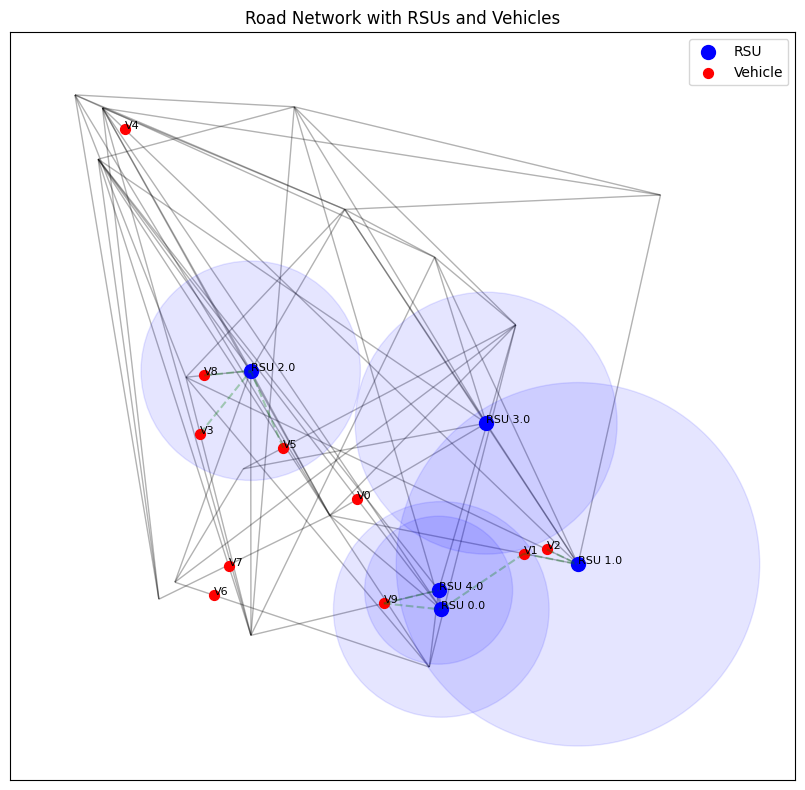

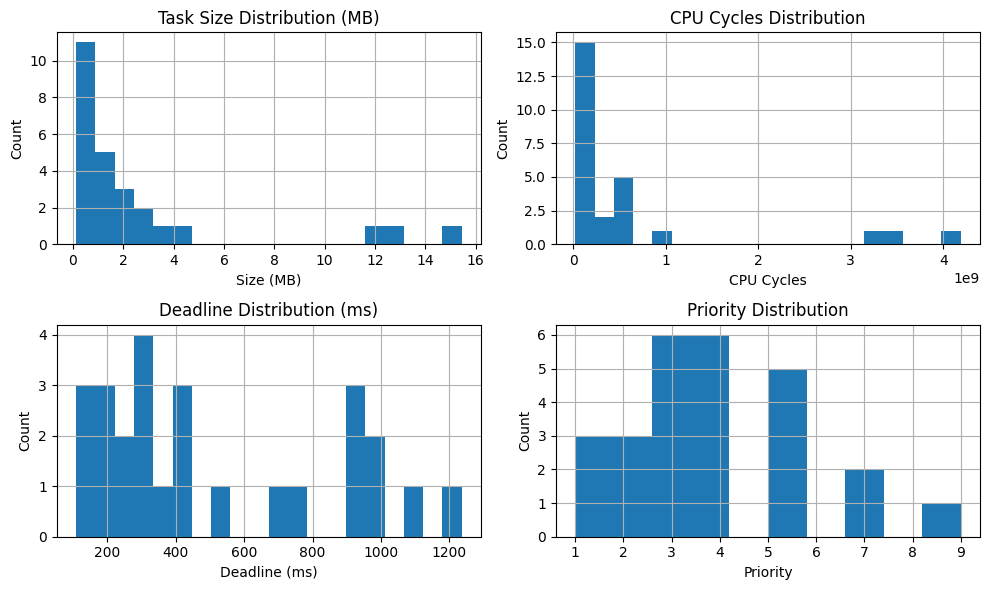

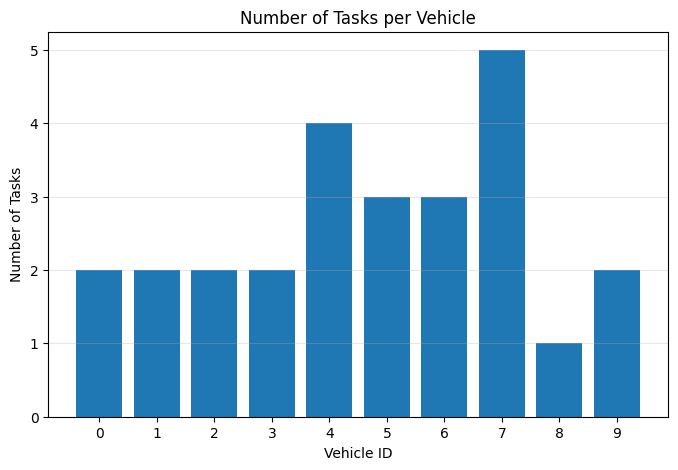

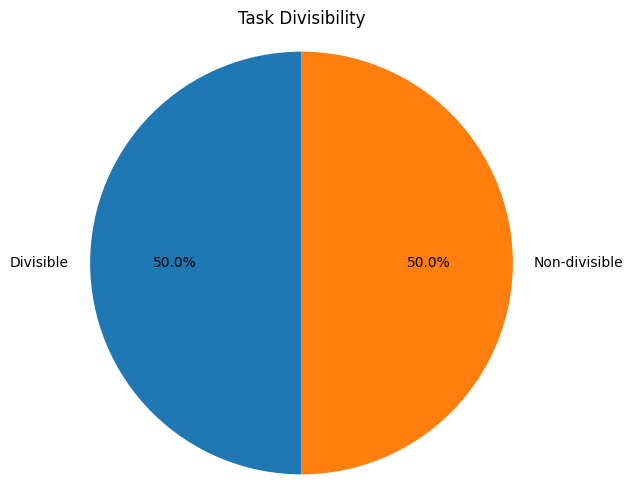

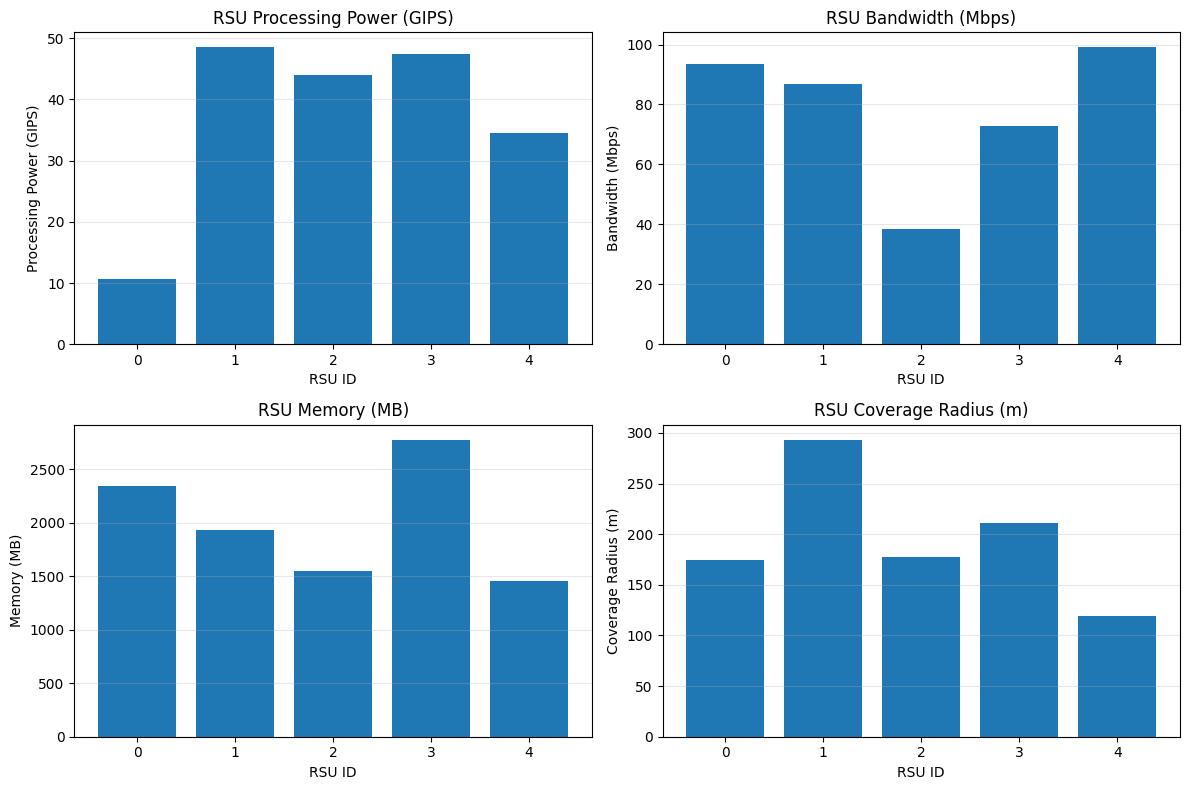

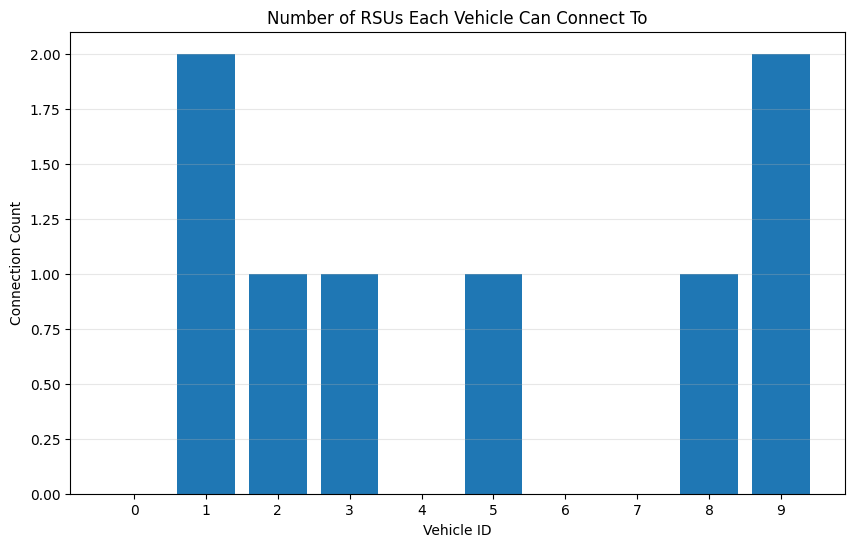

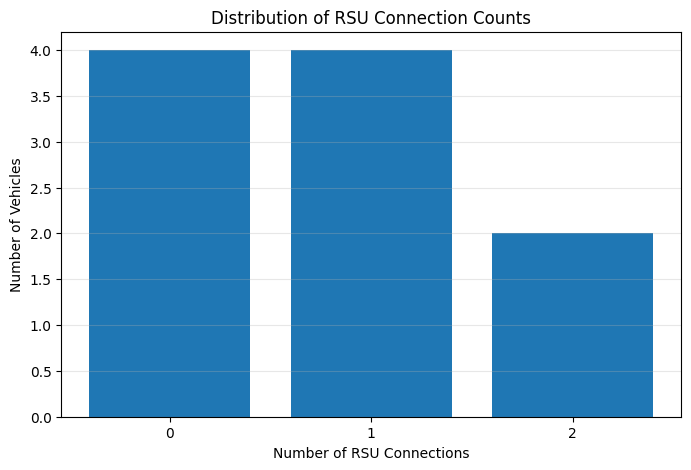

No time-evolved scenarios found.


In [10]:
# List available scenarios
scenarios = list_scenarios()
print(f"Available scenarios: {scenarios}")

if scenarios:
    # Select the first scenario for demonstration
    selected_scenario = scenarios[0]
    print(f"Selected scenario: {selected_scenario}")
    
    # Load and visualize the scenario
    scenario_data = load_scenario(selected_scenario)
    
    plot_network(scenario_data)
    analyze_tasks(scenario_data)
    analyze_rsu_resources(scenario_data)
    analyze_vehicle_connections(scenario_data)
    
    # Analyze time evolution if available
    analyze_time_evolution(selected_scenario)